In [7]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.misc import imread, imsave
import pickle
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import concatenate, Input
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import cv2

In [8]:
%matplotlib inline
sns.set_context("poster")

In [11]:
# def pipeline(image):
#     kernel_size = 5
#     gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#     blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

#     # Define parameters for Canny and run it
#     low_threshold = 60
#     high_threshold = 240
#     edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
#     return gray

In [21]:
X_train = []
XX_train = []
y_train = []

drives = ['driving_track_1_train_1.pkl',
         'driving_track_1_train_2.pkl',
         'driving_track_1_train_3.pkl',
         'driving_track_2_train_4.pkl',
         'driving_track_2_train_5.pkl',
         'driving_track_2_train_6.pkl'
         ]
for drive in drives:
    
    
    print('processing: ', drive)
    with open(drive, 'rb') as f:
        data = pickle.load(f)
    
    # add in the left and right version of this, not for sensor data, we just have 
    # to add it twice
    sensors = data['sensors'].astype(np.float64)[:,0:1] #only using the first var at this point
    images = data['images']
    steering_throttle = data['steering_throttle'].astype(np.float64)

    
    for i in range(3, len(images)):
        #sensor data is only speed at this point which is between 0 and 31. this centers the speed at 0 and 
        #changes the range to -1 to 1
        sensor_data = np.hstack([sensors[i-3:i].flatten() /  31 - .5, steering_throttle[i-3:i-1].flatten()])
        image_data = images[i]
        steering_data = steering_throttle[i][0]
        throttle_data = steering_throttle[i][1]
        
        XX_train.append(sensor_data)
        XX_train.append(sensor_data)
        
        X_train.append(image_data)
        X_train.append(np.array(np.fliplr(image_data)))
        y_train.append(np.array([steering_data, throttle_data]))
        y_train.append(np.array([-steering_data, throttle_data]))

    
X_train = np.array(X_train)
XX_train = np.array(XX_train)
y_train = np.array(y_train)

processing:  driving_track_1_train_1.pkl
processing:  driving_track_1_train_2.pkl
processing:  driving_track_1_train_3.pkl
processing:  driving_track_2_train_4.pkl
processing:  driving_track_2_train_5.pkl
processing:  driving_track_2_train_6.pkl


In [22]:
print(X_train.shape, XX_train.shape, y_train.shape)

(112236, 80, 320, 3) (112236, 7) (112236, 2)


[ 0.00643774  0.00245516 -0.01921484  0.0661055   0.          0.0661055   0.        ] [ 0.0661055  0.       ]


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


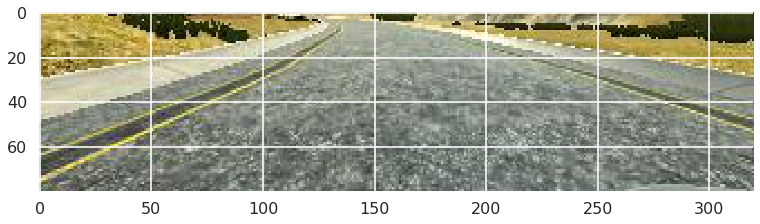

In [23]:
#view some images
preview_index = 0
print(XX_train[preview_index], y_train[preview_index])
plt.imshow(X_train[preview_index])

In [24]:
def create_model():
    model = Sequential()
    
    image_input = Input(shape=(80, 320, 3), name='image_input', dtype='float32')
    sensor_input = Input(shape=(7,), name='sensor_input', dtype='float32')
    
    # preprocess
    X = Lambda(lambda x: x/255.0 - 0.5, input_shape=(80, 320, 3))(image_input)
    # conv1 layer
    X = Convolution2D(64, (5, 5))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)
    
    # conv2 layer
    X = Convolution2D(64, (5, 5))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)
    
    # conv3 layer
    X = Convolution2D(64, (3, 3))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)
    
    # conv4 layer
    X = Convolution2D(64, (3, 3))(X)
    X = MaxPooling2D((2, 2))(X)
    X = Activation('relu')(X)

    
    X = Flatten()(X) #Flatten input image
    
    #add in the speed, here we may add in other variables such 
    # as the last several throttle / speed/ steering angles, and other sensors
    X = concatenate([X, sensor_input])
    
        
    #add fully connected layers
    
    # fc1
    X = Dense(256)(X)
    X = Dropout(0.5)(X)
    X = Activation('relu')(X)
    
    # fc2
    X = Dense(128)(X)
    X = Dropout(0.5)(X)
    X = Activation('relu')(X)
    
    # fc2
    X = Dense(64)(X)
    X = Dropout(0.5)(X)
    X = Activation('relu')(X)
    
    steer_output = Dense(1, name='steer_output')(X) #output layer with 
    throttle_output = Dense(1, name='throttle_output')(X)
    #model = Model(inputs=[image_input, sensor_input], outputs=[steer_output, throttle_output])
    model = Model(inputs=[image_input, sensor_input], outputs=[steer_output])

    
    # note, setting the loss weight to favor steering
    model.compile(optimizer='adam',
              #loss={'steer_output': 'mse', 'throttle_output': 'mse'},
              loss={'steer_output': 'mse'},
              #loss_weights={'steer_output': 1., 'throttle_output': 0.2})
              loss_weights={'steer_output': 1.0})
    
    return model

In [25]:
model = create_model()

In [26]:
# train the model and save it each eopch
for i in range(20):
    model.fit(
        {'image_input': X_train, 'sensor_input': XX_train},
        {'steer_output': y_train[:,[0]], 'throttle_output': y_train[:,[1]]}, 
        shuffle=True, epochs=3, validation_split=.3, batch_size=64)
    
    model.save("data_model_with_speed_history_canny_{}.h5".format(i))
    

Train on 78565 samples, validate on 33671 samples
Epoch 1/3
78565/78565 [==============================] - 383s - loss: 0.0300 - val_loss: 0.0262
Epoch 2/3
78565/78565 [==============================] - 381s - loss: 0.0181 - val_loss: 0.0247
Epoch 3/3
78565/78565 [==============================] - 379s - loss: 0.0151 - val_loss: 0.0211
Train on 78565 samples, validate on 33671 samples
Epoch 1/3
78565/78565 [==============================] - 379s - loss: 0.0133 - val_loss: 0.0220
Epoch 2/3
78565/78565 [==============================] - 379s - loss: 0.0124 - val_loss: 0.0224
Epoch 3/3
78565/78565 [==============================] - 379s - loss: 0.0126 - val_loss: 0.0203
Train on 78565 samples, validate on 33671 samples
Epoch 1/3
29376/78565 [==========>...................] - ETA: 209s - loss: 0.0113

KeyboardInterrupt: 

In [ ]:
#loss: 0.0199 - val_loss: 0.0819